In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
import copy
import gif
from IPython.display import Image


In [4]:
def animate(data, j, patch, head, joints):
    first = []
    second = []
    for i in joints:
        first.append(data[j][0][i])
        second.append(data[j][1][i])
    a = np.array([first, second])
    a = np.transpose(a)
    patch.set_xy(a)
    head.center = (data[j][0][5], data[j][1][5])
    return patch, head

# To create a gif image
@gif.frame
def plot_samples_normal(data, j):
    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(-0.1, 3))


    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor="k")
    head = plt.Circle((0, 0), radius=0.15, fc="k", ec="k")
    ax.add_patch(patch)
    ax.add_patch(head)
    plt.title(f"total_distance: {data[j][0][5]:.2f}")
    animate(data, j, patch, head, joints)
    # ax.Line2D([-0.5, 0], [10, 0], color='black')

    step_size = 11 / len(data)

    # Add a progress bar rectangle at the bottom
    progress_bar_height = 0.1
    progress_bar_y = -0.1  # Position of the progress bar on the y-axis
    progress_bar = plt.Rectangle((-1, progress_bar_y), step_size*j, progress_bar_height, color='blue')
    ax.add_patch(progress_bar)

    # Add a border for the progress bar
    progress_bar_border = plt.Rectangle((-1, progress_bar_y), 11, progress_bar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(progress_bar_border)



In [5]:
# plan is an array of 40 floating point numbers
def sim(plan):
    """
    Simulates the motion of a multi-jointed body based on a given plan.

    Parameters:
    plan (list of float): A list of control parameters for the simulation. Each element should be between -1 and 1.

    Returns:
    tuple:
        - data (list of list of list of float): A list of positions of the body parts at each time step. Each position is a list of two lists, representing the x and y coordinates of the body parts.
        - final_position (float): The final x-coordinate of the head (body part 5).

    The simulation involves:
    - Adjusting the control parameters to be within the range [-1, 1].
    - Initializing physical properties such as mass, edge lengths, spring constants, and damping factors.
    - Iteratively updating the positions and velocities of the body parts based on forces, torques, and constraints.
    - Handling contact with the ground and applying friction.
    - Recording the positions of the body parts at each time step.
    - Returning the recorded data and the final x-coordinate of the head.
    """
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1 # time step
    friction = 1.0 # friction coefficient
    gravity = 0.1 # gravity constant
    mass = [30, 10, 5, 10, 5, 10] # mass of body parts
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9] # edge lengths
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]    # spring constants
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]   # damping factors
    anglessp = [20.0, 20.0, 10.0, 10.0] # angular spring constants
    anglesf = [8.0, 8.0, 4.0, 4.0]  # angular damping factors

    edge = [(0, 1), (1, 2), (0, 3), (3, 4), (0, 5)] # edges
    angles = [(4, 0), (4, 2), (0, 1), (2, 3)] # angles

    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    p = [[0, 0, -0.25, 0.25, 0.25, 0.15], [1, 0.5, 0, 0.5, 0, 1.9]]

    spin = 0.0
    maxspin = 0.0
    lastang = 0.0

    data = []

    for j in range(20): # 20 time steps
        for k in range(10): # 10 substeps
            lamb = 0.05 + 0.1 * k 
            t0 = 0.5
            if j > 0:
                t0 = plan[2 * j - 2]
            t0 *= 1 - lamb
            t0 += plan[2 * j] * lamb

            t1 = 0.0
            if j > 0:
                t1 = plan[2 * j - 1]
            t1 *= 1 - lamb
            t1 += plan[2 * j + 1] * lamb

            contact = [False, False, False, False, False, False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8 + t0), -(2.8 - t0), -(1 - t1) * 0.9, -(1 + t1) * 0.9] 

            disp = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            dist = [0, 0, 0, 0, 0]
            dispn = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]] - p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]] - p[1][edge[z][0]]
                dist[z] = (
                    math.sqrt(disp[0][z] * disp[0][z] + disp[1][z] * disp[1][z]) + 0.01
                )
                inv = 1.0 / dist[z]
                dispn[0][z] = disp[0][z] * inv
                dispn[1][z] = disp[1][z] * inv 

            dispv = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            distv = [0, 0, 0, 0, 0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2 * (disp[0][z] * dispv[0][z] + disp[1][z] * dispv[1][z])

            forceedge = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                c = (edgel[z] - dist[z]) * edgesp[z] - distv[z] * edgef[z]
                forceedge[0][z] = c * dispn[0][z]
                forceedge[1][z] = c * dispn[1][z]

            edgeang = [0, 0, 0, 0, 0]
            edgeangv = [0, 0, 0, 0, 0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z] * disp[1][z] - dispv[1][z] * disp[0][z]) / (
                    dist[z] * dist[z]
                )

            inc = edgeang[4] - lastang
            if inc < -math.pi:
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - 0.005 * (k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0, 0, 0, 0]
            for z in range(4): 
                angv[z] = edgeangv[angles[z][1]] - edgeangv[angles[z][0]]

            angf = [0, 0, 0, 0]
            for z in range(4):
                ang = edgeang[angles[z][1]] - edgeang[angles[z][0]] - anglesl[z]
                if ang > math.pi:
                    ang -= 2 * math.pi
                elif ang < -math.pi:
                    ang += 2 * math.pi
                m0 = dist[angles[z][0]] / edgel[angles[z][0]]
                m1 = dist[angles[z][1]] / edgel[angles[z][1]]
                angf[z] = ang * anglessp[z] - angv[z] * anglesf[z] * min(m0, m1)

            edgetorque = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                inv = 1.0 / (dist[z] * dist[z])
                edgetorque[0][z] = -disp[1][z] * inv
                edgetorque[1][z] = disp[0][z] * inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z] * edgetorque[0][i0]
                forceedge[1][i0] += angf[z] * edgetorque[1][i0]
                forceedge[0][i1] -= angf[z] * edgetorque[0][i1]
                forceedge[1][i1] -= angf[z] * edgetorque[1][i1]

            f = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity * mass[z]
                invm = 1.0 / mass[z]
                v[0][z] += f[0][z] * dt * invm
                v[1][z] += f[1][z] * dt * invm

                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z] * s < fric * friction:
                        v[0][z] = 0
                    else:
                        v[0][z] -= fric * friction * s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt

            data.append(copy.deepcopy(p))

            if contact[0] or contact[5]:
                return data, p[0][5]
    return data, p[0][5]

In [17]:
# TODO: Design an optimization algorithm to find the optimal plan
plan = [0.8 for i in range(40)]
import numpy as np

def mcmc_optimize(sim, iters=3000, sigma=0.15, beta=3.0):
    plan = np.random.uniform(-1, 1, 40)
    _, dist = sim(plan.copy())

    best_plan = plan.copy()
    best_dist = dist

    for i in range(iters):
        proposal = plan + np.random.normal(0, sigma, size=40)
        proposal = np.clip(proposal, -1, 1)

        _, new_dist = sim(proposal.copy())

        accept_prob = np.exp(beta * (new_dist - dist))
        if np.random.rand() < accept_prob:
            plan = proposal
            dist = new_dist

        if dist > best_dist:
            best_dist = dist
            best_plan = plan.copy()

        if i % 100 == 0:
            print(f"Iter {i:4d} | Current {dist:.3f} | Best {best_dist:.3f}")

    return best_plan, best_dist
best_plan, best_dist = mcmc_optimize(sim, iters=3000, sigma=0.15, beta=3.0)

Iter    0 | Current -0.074 | Best -0.074
Iter  100 | Current 3.449 | Best 3.518
Iter  200 | Current 4.271 | Best 4.271
Iter  300 | Current 2.430 | Best 4.271
Iter  400 | Current 5.631 | Best 5.631
Iter  500 | Current 6.077 | Best 6.077
Iter  600 | Current 6.077 | Best 6.077
Iter  700 | Current 6.077 | Best 6.077
Iter  800 | Current 6.161 | Best 6.161
Iter  900 | Current 6.471 | Best 6.471
Iter 1000 | Current 6.455 | Best 6.471
Iter 1100 | Current 6.467 | Best 6.471
Iter 1200 | Current 6.938 | Best 6.938
Iter 1300 | Current 6.938 | Best 6.938
Iter 1400 | Current 6.938 | Best 6.938
Iter 1500 | Current 6.938 | Best 6.938
Iter 1600 | Current 6.938 | Best 6.938
Iter 1700 | Current 6.938 | Best 6.938
Iter 1800 | Current 6.524 | Best 6.938
Iter 1900 | Current 6.524 | Best 6.938
Iter 2000 | Current 6.380 | Best 6.938
Iter 2100 | Current 6.633 | Best 6.938
Iter 2200 | Current 4.557 | Best 6.938
Iter 2300 | Current 4.750 | Best 6.938
Iter 2400 | Current 4.750 | Best 6.938
Iter 2500 | Current 4.9

In [18]:
###########
# The following code is given as an example to store a video of the run and to display
# the run in a graphics window. You will treat sim(plan) as a black box objective
# function and maximize it.
###########
data, total_distance = sim(best_plan)
print("Total Distance = ", total_distance)

Total Distance =  6.9375990708461925


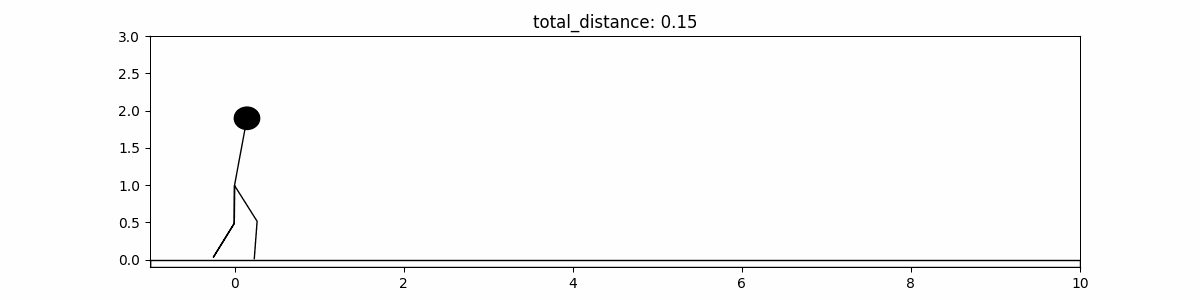

In [20]:
# Create a gif
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation-mcmc.gif", duration=40)
Image(filename="animation.gif")

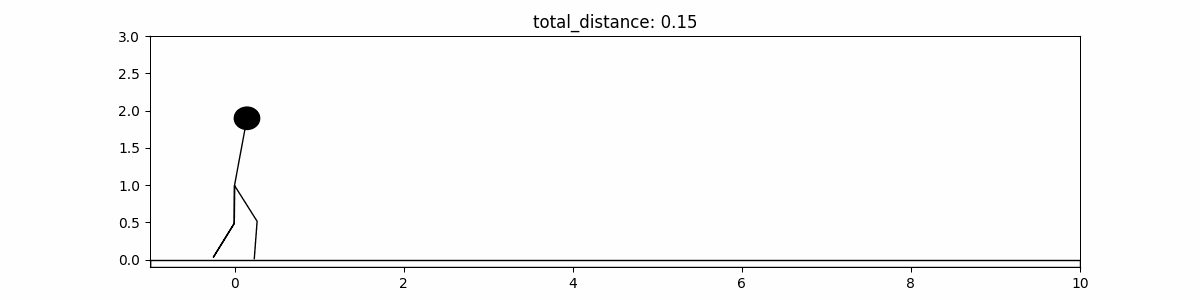

In [30]:
Image(filename="animation-mcmc.gif")

Iter     1 | T= 9.9950e-01 | sigma= 0.200 | curr=-0.5527 | best=-0.5527 | acc= 0.00%
Iter   200 | T= 9.0481e-01 | sigma= 0.181 | curr=-0.3906 | best= 2.7812 | acc= 83.00%
Iter   400 | T= 8.1869e-01 | sigma= 0.164 | curr= 2.9735 | best= 3.6532 | acc= 74.75%
Iter   600 | T= 7.4076e-01 | sigma= 0.148 | curr=-0.6555 | best= 3.9871 | acc= 72.33%
Iter   800 | T= 6.7025e-01 | sigma= 0.134 | curr= 1.7841 | best= 3.9871 | acc= 67.38%
Iter  1000 | T= 6.0645e-01 | sigma= 0.121 | curr= 2.0041 | best= 3.9871 | acc= 57.60%
Iter  1200 | T= 5.4873e-01 | sigma= 0.110 | curr= 1.0326 | best= 5.1935 | acc= 54.67%
Iter  1400 | T= 4.9650e-01 | sigma= 0.099 | curr= 5.4615 | best= 5.4615 | acc= 49.07%
Iter  1600 | T= 4.4924e-01 | sigma= 0.090 | curr= 3.5621 | best= 5.4615 | acc= 44.75%
Iter  1800 | T= 4.0648e-01 | sigma= 0.081 | curr= 2.8417 | best= 5.4615 | acc= 40.56%
Iter  2000 | T= 3.6779e-01 | sigma= 0.074 | curr= 4.0432 | best= 5.4615 | acc= 37.00%
Iter  2200 | T= 3.3278e-01 | sigma= 0.067 | curr= 3.862

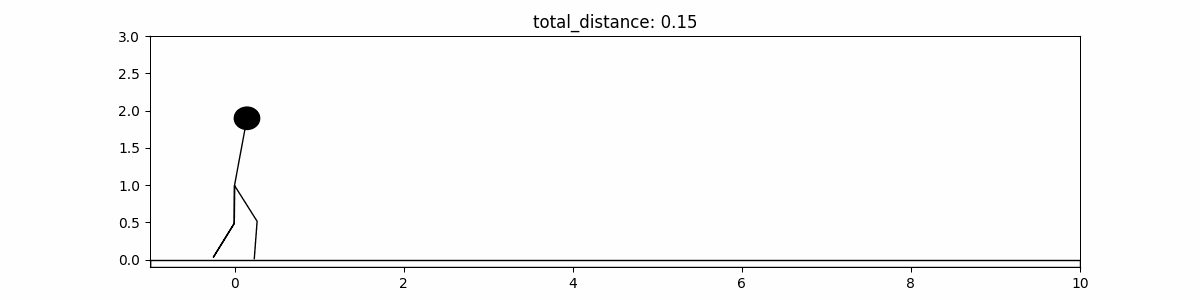

In [23]:
import numpy as np

def simulated_annealing_optimize(
    sim,
    iters=15000,
    sigma0=0.20,
    sigma_min=0.02,
    T0=1.0,
    Tmin=1e-3,
    cooling="exp",          # "exp" or "linear"
    gamma=0.9995,            # exp cooling: T <- gamma*T
    seed=None,
    verbose_every=200
):
    """
    Simulated annealing for maximizing sim(plan)[1], treating sim as a black box.

    Parameters
    ----------
    sim : callable
        sim(plan) -> (data, total_distance). plan is length-40 array-like.
    iters : int
        Number of SA iterations (proposals).
    sigma0 : float
        Initial proposal std (random-walk step size).
    sigma_min : float
        Minimum proposal std (keeps tiny exploration near the end).
    T0 : float
        Initial temperature.
    Tmin : float
        Minimum temperature.
    cooling : str
        "exp" for exponential cooling, "linear" for linear cooling.
    gamma : float
        Exponential cooling rate. Closer to 1 => slower cooling.
    seed : int or None
        RNG seed.
    verbose_every : int
        Print progress every this many iterations.

    Returns
    -------
    best_plan : np.ndarray shape (40,)
    best_dist : float
    history : dict
        Tracks best_dist over time, acceptance rate, etc.
    """
    rng = np.random.default_rng(seed)

    # --- Helper: clip into [-1, 1]
    def clip01(x):
        return np.clip(x, -1.0, 1.0)

    # --- Initialize
    current_plan = rng.uniform(-1.0, 1.0, size=40)
    _, current_dist = sim(current_plan.copy())

    best_plan = current_plan.copy()
    best_dist = float(current_dist)

    T = float(T0)
    sigma = float(sigma0)

    accepted = 0
    best_trace = [best_dist]
    curr_trace = [float(current_dist)]

    # Precompute for linear cooling
    if cooling == "linear":
        # Decrease T from T0 to Tmin across iters
        dT = (T0 - Tmin) / max(1, iters - 1)

    for i in range(1, iters + 1):
        # --- Update proposal step size (optional but practical):
        # shrink sigma slowly with temperature, but not below sigma_min
        # This makes big exploratory moves early and fine-tuning late.
        sigma = max(sigma_min, sigma0 * (T / T0))

        # --- Propose
        proposal = current_plan + rng.normal(0.0, sigma, size=40)
        proposal = clip01(proposal)

        # --- Evaluate
        _, new_dist = sim(proposal.copy())
        new_dist = float(new_dist)

        # --- Accept/reject
        delta = new_dist - current_dist

        # If better => accept
        if delta >= 0:
            accept = True
        else:
            # Accept worse with probability exp(delta / T)
            # Note: delta is negative here.
            # Guard against numerical issues when T is tiny.
            if T <= 0:
                accept = False
            else:
                accept_prob = np.exp(delta / T)
                accept = (rng.random() < accept_prob)

        if accept:
            current_plan = proposal
            current_dist = new_dist
            accepted += 1

            if new_dist > best_dist:
                best_dist = new_dist
                best_plan = proposal.copy()

        # --- Cool down temperature
        if cooling == "exp":
            T = max(Tmin, T * gamma)
        elif cooling == "linear":
            T = max(Tmin, T0 - dT * (i - 1))
        else:
            raise ValueError("cooling must be 'exp' or 'linear'")

        # --- Logging
        best_trace.append(best_dist)
        curr_trace.append(float(current_dist))

        if verbose_every and (i % verbose_every == 0 or i == 1):
            acc_rate = accepted / i
            print(
                f"Iter {i:5d} | T={T: .4e} | sigma={sigma: .3f} | "
                f"curr={current_dist: .4f} | best={best_dist: .4f} | acc={acc_rate: .2%}"
            )

    history = {
        "best_trace": np.array(best_trace, dtype=float),
        "curr_trace": np.array(curr_trace, dtype=float),
        "accept_rate": accepted / max(1, iters),
        "final_T": T,
    }
    return best_plan, best_dist, history

best_dist_final = 0.0
best_plan_final = None
for seed in range(5):
    best_plan, best_dist, _ = simulated_annealing_optimize(sim, seed=seed)
    if best_dist_final < best_dist:
        best_dist_final = best_dist
        best_plan_final = best_plan



data, total_distance = sim(best_plan_final)
print("Total Distance = ", total_distance)
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation-annealing.gif", duration=40)
#Image(filename="animation.gif")

In [24]:
data, total_distance = sim(best_plan_final)
print("Total Distance = ", total_distance)

Total Distance =  8.098842859031185


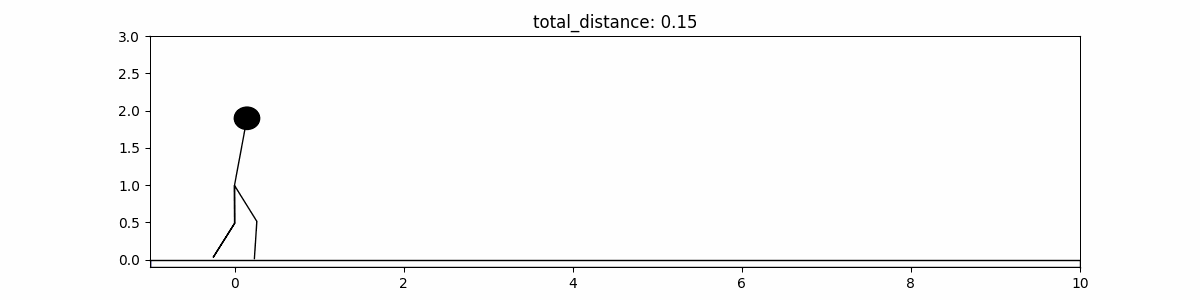

In [25]:
Image(filename="animation-annealing.gif")

In [26]:
import numpy as np

def evolutionary_optimize(
    sim,
    pop_size=40,
    elite_frac=0.2,
    generations=200,
    sigma0=0.2,
    sigma_min=0.03,
    seed=None,
    verbose_every=10
):
    """
    Evolutionary algorithm for maximizing sim(plan)[1].

    Parameters
    ----------
    sim : callable
        sim(plan) -> (data, distance)
    pop_size : int
        Population size
    elite_frac : float
        Fraction of population kept as elites
    generations : int
        Number of generations
    sigma0 : float
        Initial mutation std
    sigma_min : float
        Minimum mutation std
    seed : int or None
        RNG seed
    verbose_every : int
        Logging interval

    Returns
    -------
    best_plan : np.ndarray (40,)
    best_dist : float
    """

    rng = np.random.default_rng(seed)
    elite_size = max(1, int(pop_size * elite_frac))

    # --- Initialize population
    population = rng.uniform(-1.0, 1.0, size=(pop_size, 40))

    best_plan = None
    best_dist = -np.inf

    for gen in range(1, generations + 1):
        # --- Evaluate population
        fitness = np.zeros(pop_size)
        for i in range(pop_size):
            _, fitness[i] = sim(population[i].copy())

        # --- Sort by fitness (descending)
        idx = np.argsort(fitness)[::-1]
        population = population[idx]
        fitness = fitness[idx]

        # --- Track best ever
        if fitness[0] > best_dist:
            best_dist = fitness[0]
            best_plan = population[0].copy()

        # --- Logging
        if gen % verbose_every == 0 or gen == 1:
            print(
                f"Gen {gen:4d} | "
                f"best={fitness[0]:.4f} | "
                f"mean={fitness.mean():.4f}"
            )

        # --- Elitism
        elites = population[:elite_size]

        # --- Mutation strength annealing
        sigma = max(sigma_min, sigma0 * (1 - gen / generations))

        # --- Generate offspring
        offspring = []
        while len(offspring) < pop_size - elite_size:
            parent = elites[rng.integers(elite_size)]
            child = parent + rng.normal(0.0, sigma, size=40)
            child = np.clip(child, -1.0, 1.0)
            offspring.append(child)

        # --- New population
        population = np.vstack([elites, offspring])

    return best_plan, best_dist


In [27]:
best_plan, best_dist = evolutionary_optimize(
    sim,
    pop_size=50,
    generations=300,
    seed=0
)

print("Best distance:", best_dist)


Gen    1 | best=2.4743 | mean=0.0153
Gen   10 | best=4.5172 | mean=1.5400
Gen   20 | best=4.7414 | mean=1.9765
Gen   30 | best=5.4217 | mean=2.1691
Gen   40 | best=5.4217 | mean=2.4727
Gen   50 | best=5.4217 | mean=2.4206
Gen   60 | best=5.4217 | mean=2.6341
Gen   70 | best=5.4217 | mean=2.5594
Gen   80 | best=5.4217 | mean=2.6009
Gen   90 | best=5.6818 | mean=3.0177
Gen  100 | best=6.3689 | mean=3.4540
Gen  110 | best=6.4278 | mean=3.6880
Gen  120 | best=6.4278 | mean=3.8015
Gen  130 | best=6.4688 | mean=3.8222
Gen  140 | best=6.6948 | mean=4.3833
Gen  150 | best=6.6948 | mean=4.0192
Gen  160 | best=6.7548 | mean=4.4026
Gen  170 | best=6.7548 | mean=4.3132
Gen  180 | best=6.9751 | mean=4.8865
Gen  190 | best=6.9751 | mean=4.8637
Gen  200 | best=7.0269 | mean=4.7919
Gen  210 | best=7.1491 | mean=5.1617
Gen  220 | best=7.1799 | mean=5.1912
Gen  230 | best=7.1799 | mean=5.0695
Gen  240 | best=7.3372 | mean=5.1033
Gen  250 | best=7.3372 | mean=5.5523
Gen  260 | best=7.3846 | mean=5.9100
G

Total Distance =  7.522351094812475


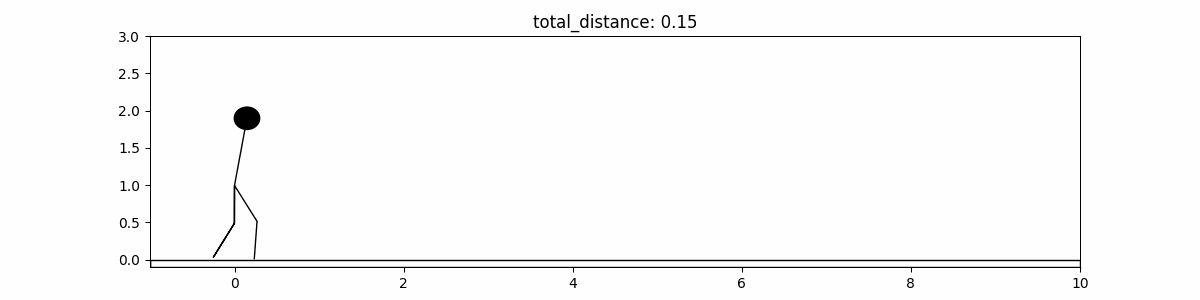

In [28]:
data, total_distance = sim(best_plan)
print("Total Distance = ", total_distance)
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation-evolve.gif", duration=40)
Image(filename="animation-evolve.gif")

In [31]:
print(best_dist_final)
print(best_plan_final)

8.098842859031185
[-0.97278373 -0.57737419  0.00292597  0.8835827  -0.97122778 -0.28586837
 -0.99218496 -1.          0.71684636 -0.88163285  0.87246119  0.71388768
  0.30374303 -0.95070415 -0.46725568  0.85233703  0.08473033 -0.63531439
  0.80899538 -0.85422772 -0.13108893  0.33853553 -0.02336179  0.51802546
 -0.75028103 -0.99407717  0.51090083 -0.49903362 -0.13439584  0.91781056
  0.47072739 -0.72907147  0.81718106  0.15784046  0.46555984  0.12330491
 -0.84375666 -0.39611177 -0.93409032 -0.85441671]
